# Librerías

In [1]:
# ! pip install optuna
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, r2_score, recall_score, f1_score
import random
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as PipelineRes
from sklearn.impute import SimpleImputer
import streamlit as st
import joblib
import warnings
warnings.simplefilter('ignore')

import shap


c:\Users\garci\OneDrive\Escritorio\TUIA\Aprendizaje Automatico 1\tp1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

Separamos nuestro dataset en la variable independiente y las variables dependientes para Regresion y Clasificacion.


Para la regresion la variable dependiente es 'RailfallTomorrow' y las variables dependientes todas las demás columnas.

In [3]:
X_train_reg = train_data.drop(columns = ["RainfallTomorrow" , "RainTomorrow"] , axis= 1)
y_train_reg = train_data['RainfallTomorrow']
X_test_reg = test_data.drop(columns = ["RainfallTomorrow" , "RainTomorrow"], axis= 1)
y_test_reg = test_data['RainfallTomorrow']

# Regresión Lineal

# Creación y entrenamiento del modelo
La idea es estandarizar los datos para tener todo en la misma escala. Esto presenta muchas ventajas a la hora de regularizar. 
Lo que hacemos es una "tubería": vamos a escalar los datos y luego hacer una regresión lineal. Cuando fiteemos esta tubería, el fit se va a hacer tanto en el scaler como en la regresión lineal. A la hora de predecir datos, está bueno porque solo vamos a usar el método predict de la tubería y eso automáticamente va a usar el transform del scaler y el predict de la regresión lineal ahorra muchos pasos, estandariza los procesos, recomendamos su uso aunque NO es estrictamente necesario, simplemente pueden usar los componentes por separado.


In [6]:
numeric_reg_features = X_train_reg.select_dtypes(exclude=['object']).columns.tolist()
categorical_reg_features = X_train_reg.select_dtypes(include=['object']).columns.tolist()

In [7]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_Reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_reg_features),
        ('cat', categorical_transformer, categorical_reg_features)
    ])

In [8]:
LR_model = Pipeline(steps=[ ('preprocessor', preprocessor_Reg) , ('regressor', LinearRegression())])

El método fit que se utiliza a continuación ajusta el modelo a los datos de entrenamiento, lo que significa que el modelo aprenderá de los ejemplos de entrenamiento y ajustará sus parámetros internos de manera que sea capaz de hacer predicciones en función de esos datos.

In [79]:
len(X_train_reg.columns.tolist())

15

In [9]:
LR_model.fit(X_train_reg, y_train_reg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindSpeed',
                                                   'Humidity', 'Pressure',
                                                   'Cloud', 'Año', 'Mes',
                                                   'Dia']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'RainToday',
                                                   'WindDir'])])),
                ('regressor', LinearRegression())])

In [10]:
LR_model.steps[1][1].coef_.flatten()

array([-1.66273750e-02,  6.22368799e-01,  1.07131864e+00,  9.51325632e-03,
       -1.15194468e+00,  9.14916753e-01,  1.68115965e+00, -4.47355581e-01,
        2.49600168e-02,  2.31326236e-02,  2.23661731e-01, -1.95385491e-03,
       -7.45572930e+12, -7.45572930e+12, -7.45572930e+12, -7.45572930e+12,
       -7.45572930e+12,  1.28512970e+11,  1.28512970e+11,  2.64904039e+12,
        2.64904039e+12,  2.64904039e+12,  2.64904039e+12,  2.64904039e+12,
        2.64904039e+12,  2.64904039e+12,  2.64904039e+12,  2.64904039e+12,
        2.64904039e+12,  2.64904039e+12,  2.64904039e+12,  2.64904039e+12,
        2.64904039e+12,  2.64904039e+12,  2.64904039e+12])

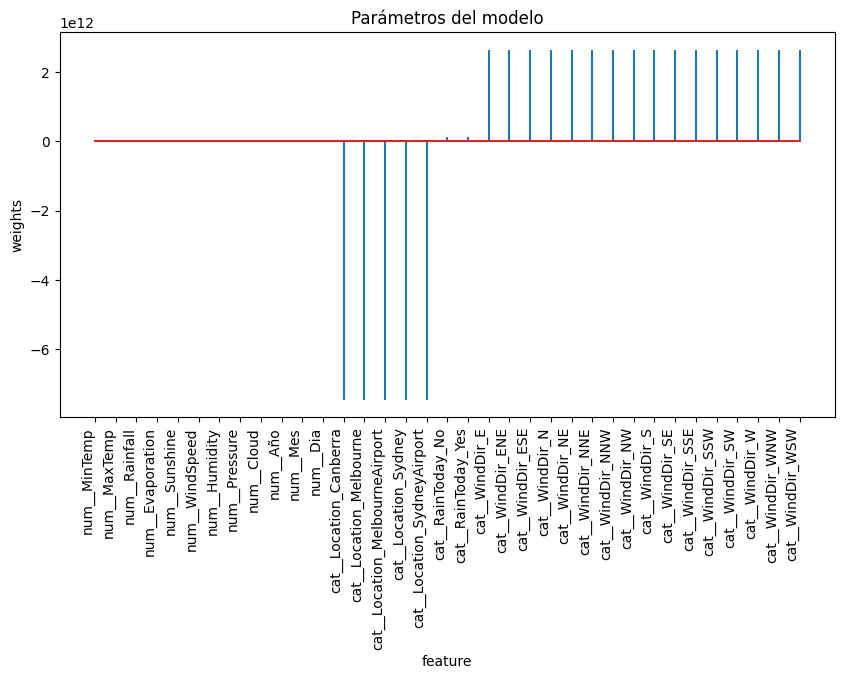

In [11]:
feature_names_after_preprocessing = preprocessor_Reg.get_feature_names_out(X_train_reg.columns)

# Crear DataFrame con nombres de características y coeficientes
df_coeficientes = pd.DataFrame({'predictor': feature_names_after_preprocessing, 'coef': LR_model.steps[1][1].coef_.flatten()})

# Graficar los coeficientes
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()

En el gráfico de tallo anterior podemos ver como influyen las distintas características a las predicciones. Podemos observar que la variable que más impacto tiene es 'RainTomorrow_Yes', seguida por 'Humidity3pm' y 'Pressure9pm'

In [12]:
# Predicciones
lr_pred = LR_model.predict(X_test_reg)
#predicciones = predicciones.flatten()
#predicciones[:10]
lr_pred.shape, y_test_reg.shape

((3021,), (3021,))

Calculamos algunas métricas para evaluar el modelo

In [13]:
# Error de test del modelo. Uso rmse para mantener la misma escala que la variable a predecir

rmse_ols = mean_squared_error(y_test_reg, lr_pred, squared = False)

print(f"El error (rmse) de test es: ",rmse_ols.round(4))

El error (rmse) de test es:  6.988


Un RMSE de 5.9938 indica que, en promedio, las predicciones del modelo están desviadas de los valores reales en el conjunto de prueba por alrededor de 5.9938 unidades en la misma escala que los valores objetivo, es decir mm. Esto significa que, en promedio, las predicciones del modelo tienden a estar a unos 5.9938 mm de distancia de las etiquetas reales. Que en contextos de lluvia es relativamente poco.

In [14]:
lr_R2 = r2_score(y_test_reg, lr_pred)
print('El coeficien de regresión es: ',lr_R2.round(4))

El coeficien de regresión es:  0.2265


Un R-cuadrado de 0.3755 indica que el modelo de regresión lineal no es muy bueno para explicar la variación en los valores objetivo en el conjunto de prueba y que podría ser necesario considerar otros modelos o mejoras en el proceso de modelado para obtener un mejor ajuste a los datos.

In [15]:
X_train_reg_scld = preprocessor_Reg.fit_transform(X_train_reg)
X_test_reg_scld = preprocessor_Reg.transform(X_test_reg)


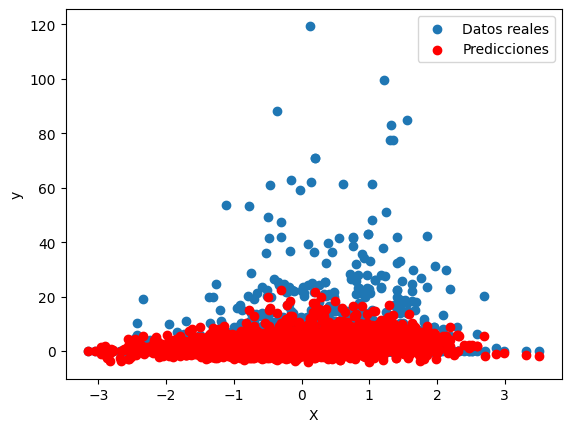

In [16]:
plt.scatter(X_test_reg_scld[:, 0], y_test_reg, label='Datos reales')
plt.scatter(X_test_reg_scld[:, 0], lr_pred, color='red', label='Predicciones')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

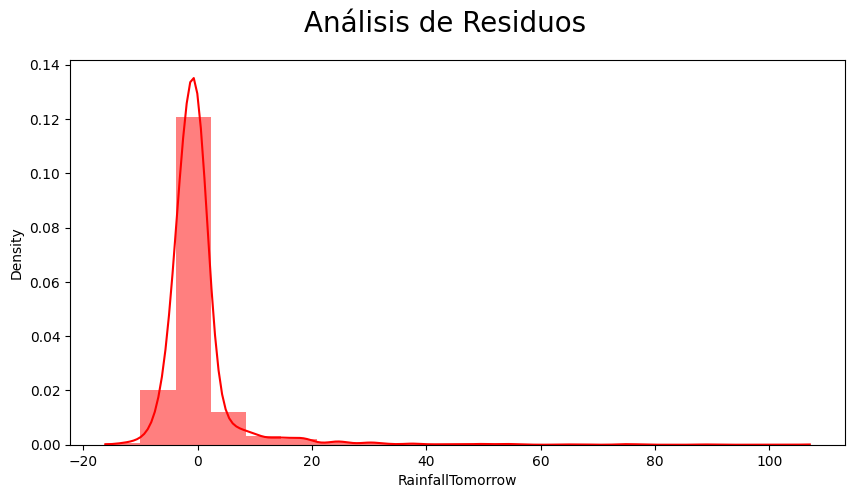

In [17]:
fig = plt.figure(figsize=(10,5))
  
sns.histplot((y_test_reg - lr_pred), color="red", kde=True, stat="density", linewidth=0,bins=20)
fig.suptitle('Análisis de Residuos', fontsize = 20)    
plt.show()

Vemos que el histograma muestra una distribución asimétrica, con una cola larga a la derecha, puede indicar que el modelo no está capturando completamente la variabilidad en los datos. Esto puede sugerir que el modelo tiene sesgos o que hay patrones no lineales en los datos que no se están teniendo en cuenta.
De todos modos se puede observar que los residuos tienen una distribución alrededor de cero, lo que significa que, en promedio, no debería haber un sesgo sistemático en las predicciones del modelo.

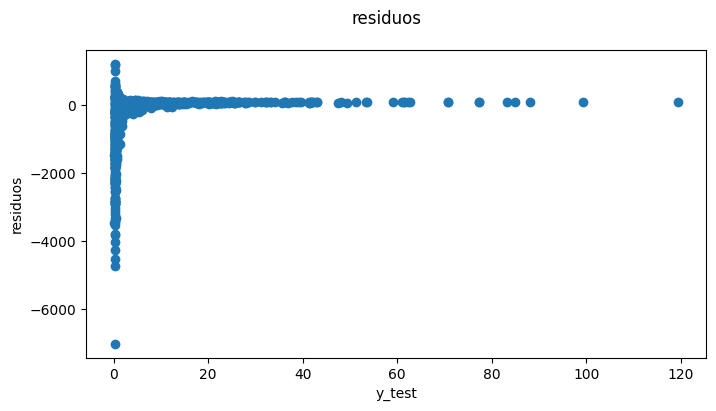

In [18]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test_reg,100*(y_test_reg-lr_pred)/y_test_reg)
plt.show()

# Ridge

In [19]:
Ridge_CV = RidgeCV(alphas = np.logspace(-10, 10, 200), fit_intercept = True, store_cv_values = True)
Ridge_Lr_Model = Pipeline(steps=[ ('preprocessor', preprocessor_Reg) , ('regressor',Ridge_CV)])


In [20]:
Ridge_Lr_Model.fit(X_train_reg, y_train_reg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindSpeed',
                                                   'Humidity', 'Pressure',
                                                   'Cloud', 'Año', 'Mes',
                                                   'Dia']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'RainToday',
                                                   'WindDir'])])),...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
                         store_cv_values=True))])

In [21]:
alphas = Ridge_Lr_Model.steps[1][1].alphas
coefs = []

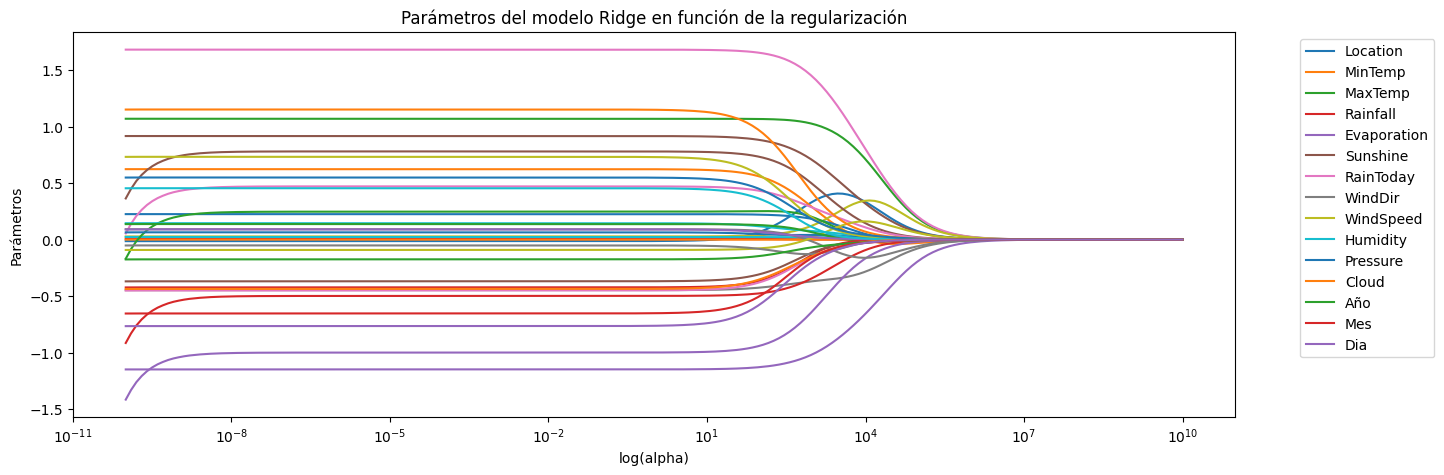

In [22]:
for alpha in alphas:
    modelo_aux = make_pipeline(preprocessor_Reg, Ridge(alpha=alpha))
    modelo_aux.fit(X_train_reg, y_train_reg)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo Ridge en función de la regularización')
ax.legend(X_train_reg.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

En el gráfico anterior podemos observar que a medida que alpha aumenta, la regularización se vuelve más fuerte, y los coeficientes tienden a disminuir hacia cero. Esto es una característica de Ridge, que ayuda a evitar el sobreajuste al penalizar coeficientes más grandes.
Podemos observar que el modelo converge a medida que el valor se acerca a 10^3


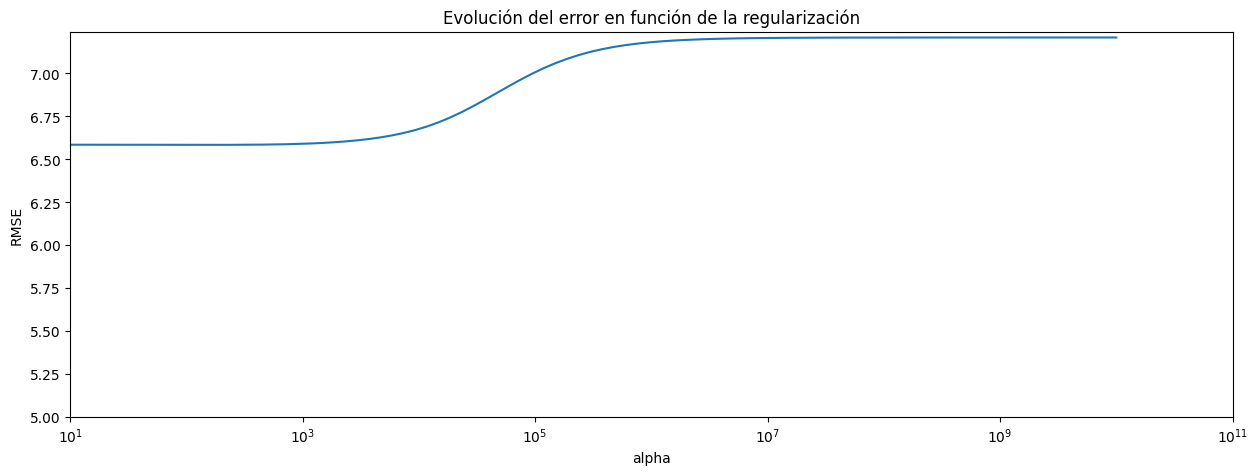

In [23]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el MSE de CV para cada valor de alpha.

mod = Ridge_Lr_Model.steps[1][1]

mse_cv = mod.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([5,None])
ax.set_xlim([10,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

A medida que alpha aumenta (la regularización se vuelve más fuerte), el RMSE de CV tiende a aumentar. Esto se debe a que la regularización penaliza coeficientes más grandes, lo que puede hacer que el modelo se ajuste menos a los datos de entrenamiento.

In [24]:
# Mejor valor alpha encontrado
alfa = mod.alpha_.round(4)
print(f"Mejor valor de alpha encontrado:", alfa)

Mejor valor de alpha encontrado: 144.8118


Este es el valor específico de alpha que minimiza el error (RMSE) en el conjunto de validación cruzada. Indica cuánta regularización se debe aplicar al modelo para obtener un equilibrio óptimo entre el ajuste a los datos y la capacidad de generalización.

In [25]:
# Predicciones test
Ridge_pred = Ridge_Lr_Model.predict(X_test_reg)

In [26]:
# Error de test del modelo 

rmse_ridge = mean_squared_error(y_test_reg,
                Ridge_pred,
                squared = False
             )

print("El error (rmse) de test es: ", rmse_ridge.round(4))

El error (rmse) de test es:  6.9983


El error (RMSE) de test es: 5.9944 significa que, en promedio, las predicciones del modelo Ridge están desviadas de los valores reales en el conjunto de prueba por alrededor de 5.9944 unidades en la misma escala que los valores objetivo. Esto sugiere que el modelo Ridge tiene un rendimiento muy similar al modelo de regresión lineal utilizado anteriormente (5.9944).

In [27]:
ridge_R2 = r2_score(y_test_reg, Ridge_pred)
print("El coeficiente de regresión es de: ", ridge_R2.round(4))

El coeficiente de regresión es de:  0.2242


El valor obtenido indica que el modelo Ridge no es muy bueno para explicar la variación en los valores objetivo en el conjunto de prueba y que podría ser necesario considerar otros modelos o mejoras en el proceso de modelado para obtener un mejor ajuste a los datos.

Dado que el R-cuadrado del modelo Ridge (0.3754) es muy similar al R-cuadrado del modelo de regresión lineal (0.3754), parece que ambos modelos tienen un rendimiento bastante similar en términos de su capacidad para explicar la variabilidad en los datos.

# Lasso Regression

Aplicamos Regularizacion Lasso, realizando Cross Validation para optimizar el hiper-parametro alpha de la regularizacion

In [28]:
lasso = LassoCV(alphas=np.logspace(-10, 10, 200), cv=10)

Lasso_Lr_Model = Pipeline(steps=[ ('preprocessor', preprocessor_Reg) , ('regressor', lasso)])

In [29]:
Lasso_Lr_Model.fit(X_train_reg, y_train_reg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindSpeed',
                                                   'Humidity', 'Pressure',
                                                   'Cloud', 'Año', 'Mes',
                                                   'Dia']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'RainToday',
                                                   'WindDir'])])),...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
                         cv=10))])

In [30]:
mod = Lasso_Lr_Model.steps[1][1]

alphas = mod.alphas_
coefs = []

In [31]:
for alpha in alphas:
    modelo_aux = make_pipeline(preprocessor_Reg, Lasso(alpha=alpha))
    modelo_aux.fit(X_train_reg, y_train_reg)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


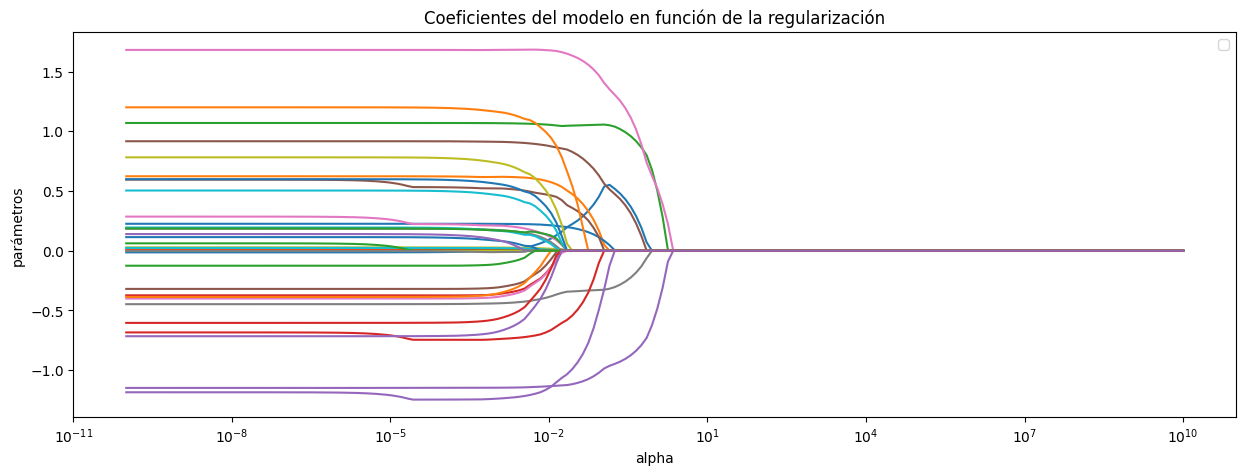

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Mejor valor alpha encontrado con Cross Validation

In [33]:
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 0.027682866303920722


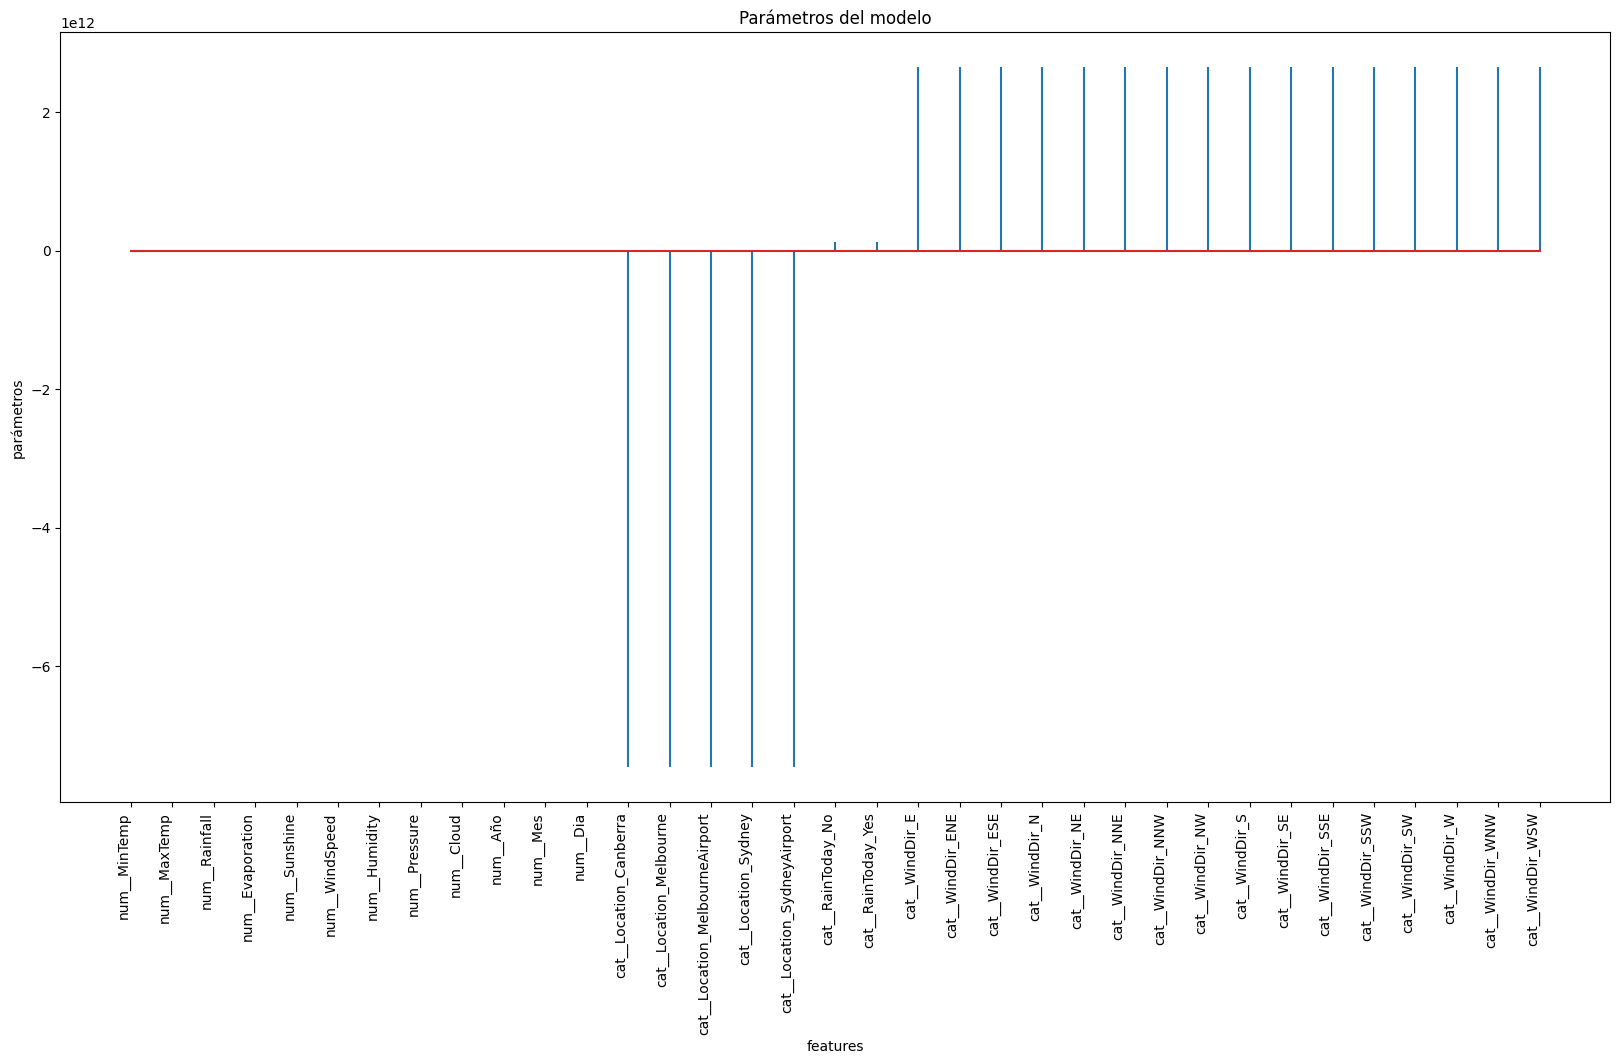

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [35]:
lasso_pred = Lasso_Lr_Model.predict(X_test_reg)

In [36]:
# Error de test del modelo 

rmse_lasso = mean_squared_error(y_test_reg,lasso_pred,squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 7.021415297532674


In [37]:
lasso_R2 = r2_score(y_test_reg, lasso_pred)
lasso_R2

0.2190613063203528

In [38]:
RCuadrados = {
    'Modelo': ['Regresión Lineal', 'Ridge', 'Lasso'],
    'R²': [lr_R2, ridge_R2, lasso_R2],  # Puedes ajustar los valores según tus resultados
    'MSE': [rmse_ols,rmse_ridge, rmse_lasso ]  # Puedes ajustar los valores según tus resultados
}

df_resultados_regresiones = pd.DataFrame(RCuadrados)

In [39]:
print(df_resultados_regresiones)

             Modelo        R²       MSE
0  Regresión Lineal  0.226477  6.987998
1             Ridge  0.224189  6.998328
2             Lasso  0.219061  7.021415


# ElasticNet

In [40]:
En_Model = make_pipeline(preprocessor_Reg,ElasticNetCV(l1_ratio = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99], alphas = np.logspace(-10, 10, 200),cv = 10 ))


In [41]:
En_Model.fit(X_train_reg, y_train_reg)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindSpeed',
                                                   'Humidity', 'Pressure',
                                                   'Cloud', 'Año', 'Mes',
                                                   'Dia']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'RainToday',
                                                   'WindDir']...
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
                              cv=10,
                              l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]))])

In [42]:
mod = En_Model.steps[1][1]

In [43]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv


,l1_ratio,mod.alphas_,mse_cv,rmse_cv
1315,0.99,2.768287e-02,43.430491,6.590181
1115,0.95,2.768287e-02,43.433113,6.590380
915,0.90,2.768287e-02,43.436501,6.590637
1314,0.99,3.489101e-02,43.437119,6.590684
1114,0.95,3.489101e-02,43.437467,6.590711
...,...,...,...,...
1023,0.95,4.880252e+07,51.987924,7.210265
1024,0.95,3.872039e+07,51.987924,7.210265
1025,0.95,3.072113e+07,51.987924,7.210265
1019,0.95,1.231551e+08,51.987924,7.210265


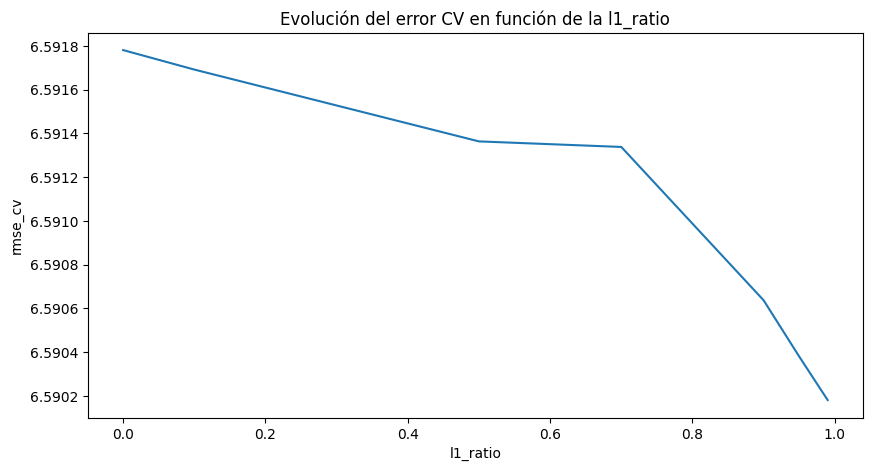

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

El gráfico muestra una curva que representa cómo cambia el RMSE de CV a medida que varía el valor de l1_ratio. Esta curva te permite identificar el valor óptimo de l1_ratio que minimiza el RMSE de CV y, por lo tanto, proporciona el mejor rendimiento del modelo.

In [45]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: ", mod.alpha_.round(4))
print(f"Mejor valor de l1_ratio encontrado:", mod.l1_ratio_)

Mejor valor de alpha encontrado:  0.0277
Mejor valor de l1_ratio encontrado: 0.99


Tener en cuenta que L1 es el maximo disponible, por ende quizas si aumento el umbral de posibles valores siga tomando alguno mayor

In [46]:
# Predicciones test
EN_pred = En_Model.predict(X_test_reg)
# Error de test del modelo 

rmse_elastic = mean_squared_error(y_test_reg, EN_pred, squared = False)

In [47]:
print(f"El error (rmse) de test es: {rmse_elastic}")

El error (rmse) de test es: 7.0213763582861874


In [48]:
elasticnet_R2 = r2_score(y_test_reg, EN_pred)
elasticnet_R2.round(4)

0.2191

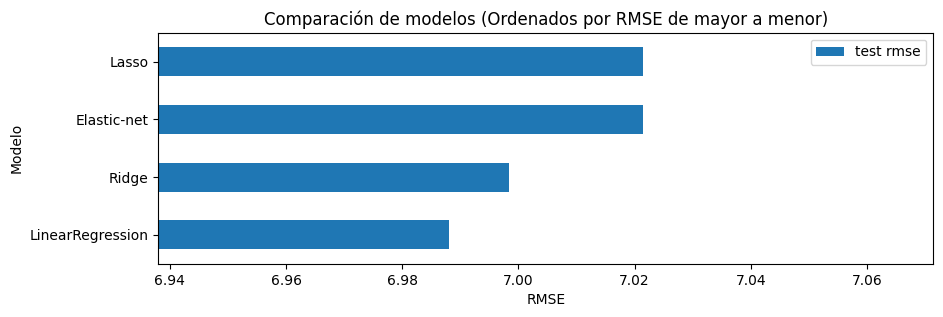

In [49]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

df_comparacion_sorted = df_comparacion.sort_values(by='test rmse', ascending=True)

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion_sorted.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('RMSE')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de modelos (Ordenados por RMSE de mayor a menor)')
ax.set_xlim(df_comparacion_sorted['test rmse'].min() - 0.05, df_comparacion_sorted['test rmse'].max() + 0.05 )

plt.show()

In [50]:
df_comparacion_sorted

,modelo,test rmse
0,LinearRegression,6.987998
1,Ridge,6.998328
3,Elastic-net,7.021376
2,Lasso,7.021415


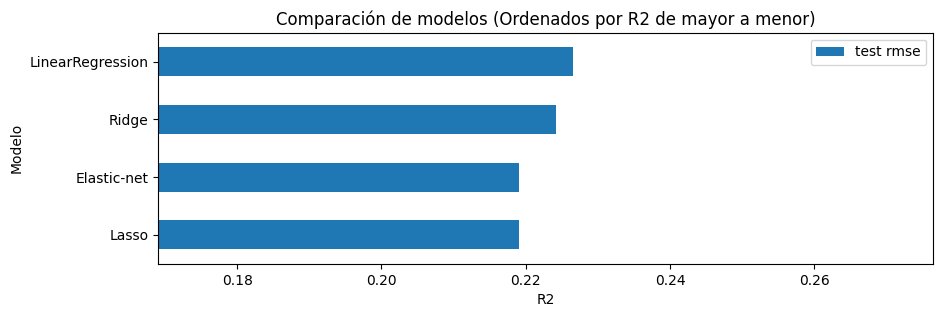

In [51]:
df_comparacion_R2 = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [lr_R2, ridge_R2 , lasso_R2, elasticnet_R2]
                 })

df_comparacion_r2_sorted = df_comparacion_R2.sort_values(by='test rmse', ascending=True)

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion_r2_sorted.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('R2')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de modelos (Ordenados por R2 de mayor a menor)')
ax.set_xlim(df_comparacion_r2_sorted['test rmse'].min() - 0.05, df_comparacion_r2_sorted['test rmse'].max() + 0.05) 

plt.show()

In [52]:
df_comparacion_R2

,modelo,test rmse
0,LinearRegression,0.226477
1,Ridge,0.224189
2,Lasso,0.219061
3,Elastic-net,0.219070


En general, todos los modelos tienen un R2 que oscila alrededor de 0.34. Esto significa que aproximadamente el 34% de la variabilidad en los datos de nuestros modelos se pueden explicar mediante la regresión.

Tambien los valores de R2 son prácticamente idénticos, lo que dice que estos modelos tienen un rendimiento muy similar en términos de la cantidad de variabilidad explicada.

Sin embargo, hay que tener en cuenta que los valores de R2 son relativamente bajos, lo que indica que el modelo no explica una gran parte de la variabilidad en los datos.

# Gradiente descendiente


In [53]:
def gradient_descent(X_train_reg, y_train_reg, X_test_reg, y_test_reg, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train_reg.shape[0]
    m = X_train_reg.shape[1]
    
    o = X_test_reg.shape[0]

    # Poner columna de unos a las matrices X
    X_train_GD = np.hstack((np.ones((n, 1)), X_train_reg))
    X_test_GD = np.hstack((np.ones((o, 1)), X_test_reg))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train_GD, W) 
        error_train = y_train_reg - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test_GD, W) 
        error_test = y_test_reg - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train_GD, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [54]:
def stochastic_gradient_descent(X_train_reg, y_train_reg, X_test_reg, y_test_reg, lr=0.01, epochs=100):
    
    n = X_train_reg.shape[0]
    m = X_train_reg.shape[1]

    X_train_SGD = np.hstack((np.ones((n, 1)), X_train_reg))
    X_test_SGD = np.hstack((np.ones((X_test_reg.shape[0], 1)), X_test_reg))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train_SGD = X_train_SGD[permutation]
        y_train = y_train_reg[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train_SGD[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test_reg, W)
            error_test = y_test_reg - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [55]:
def mini_batch_gradient_descent(X_train_reg, y_train_reg, X_test_reg, y_test_reg, lr=0.01, epochs=100, batch_size=11):
    n = X_train_reg.shape[0]
    m = X_train_reg.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train_reg))
    X_test = np.hstack((np.ones((X_test_reg.shape[0], 1)), X_test_reg))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train_reg[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test_reg - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

Para este modelo debemos transfomar los datasets con el procesador

In [56]:
train_data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,RainToday,RainTomorrow,RainfallTomorrow,WindDir,WindSpeed,Humidity,Pressure,Cloud,Año,Mes,Dia
0,Canberra,11.20,23.95,0.0,3.4,6.3,No,Yes,3.6,NW,18.666667,48.5,1017.35,7.0,2007,11,1
1,Canberra,15.75,26.30,3.6,4.4,9.7,Yes,Yes,3.6,E,20.000000,58.0,1010.40,4.0,2007,11,2
2,Canberra,14.55,21.80,3.6,5.8,3.3,Yes,Yes,39.8,N,32.333333,75.5,1008.35,7.5,2007,11,3
3,Canberra,13.40,14.80,39.8,7.2,9.1,Yes,Yes,2.8,NW,36.000000,59.0,1006.25,4.5,2007,11,4
4,Canberra,8.55,15.85,0.0,5.8,8.2,No,No,0.2,SE,29.333333,63.5,1022.75,6.0,2007,11,6


Armamos nuestros dataframes con los valores normalizados

In [57]:
train_data_transformed = pd.concat([pd.DataFrame(preprocessor_Reg.fit_transform(train_data), columns=preprocessor_Reg.get_feature_names_out(train_data.columns))], axis=1)
test_data_transformed = pd.concat([pd.DataFrame(preprocessor_Reg.transform(test_data), columns=preprocessor_Reg.get_feature_names_out(test_data.columns))], axis=1)


Con la lluvia de hoy predecimos mañana

In [61]:
X_train_GD = train_data_transformed['num__Rainfall'].values.reshape(-1,1)
X_test_GD = test_data_transformed['num__Rainfall'].values.reshape(-1,1)
y_train_GD = y_train_reg.values.reshape(-1,1)
y_test_GD = y_test_reg.values.reshape(-1,1)

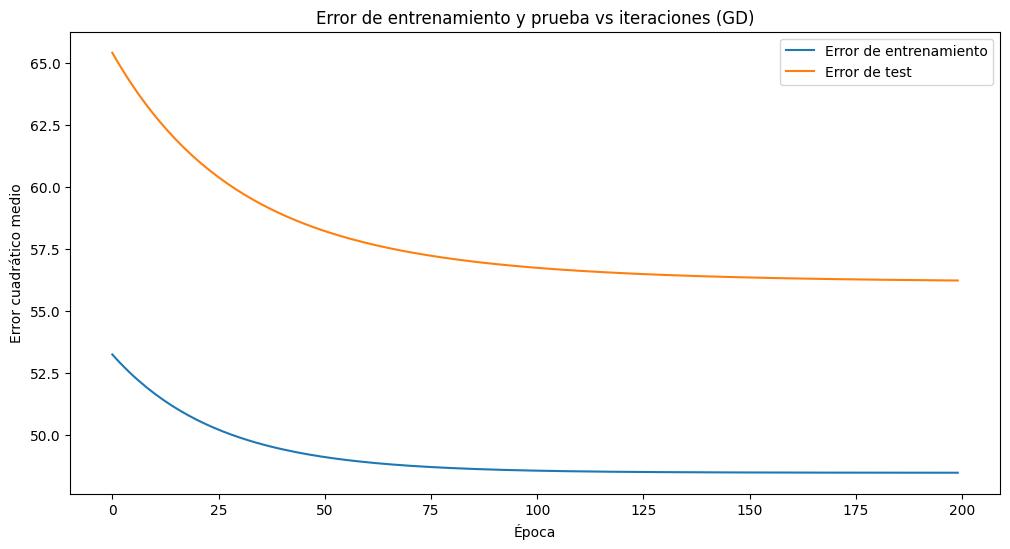

array([[2.21970272],
       [1.8329586 ]])

In [62]:
gradient_descent(X_train_GD, y_train_GD, X_test_GD, y_test_GD, lr=0.01, epochs=200)

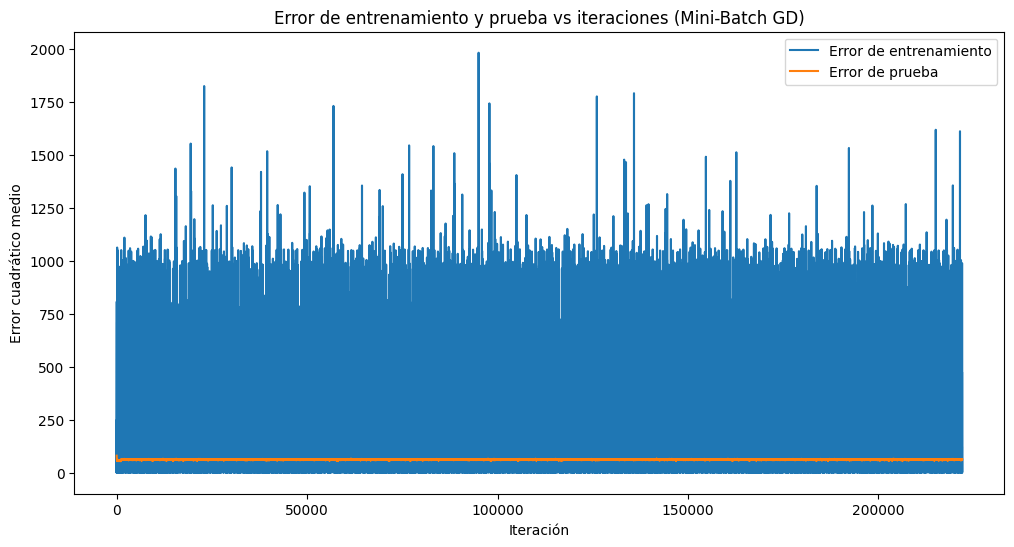

array([[ 2.04516037],
       [-0.10902787]])

In [63]:
mini_batch_gradient_descent(X_train_GD, y_train_GD, X_test_GD, y_test_GD, epochs=200)

Red Neuronal para Regresion

In [64]:
X_train_reg_scld = preprocessor_Reg.fit_transform(X_train_reg)
X_test_reg_scld = preprocessor_Reg.transform(X_test_reg)

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=[X_train_reg_scld.shape[1]]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Utilizamos adam como funcion de activacion y MSE como funcion de perdida
model.compile(optimizer='adam', loss='mean_squared_error')

# Imprimir un resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train_reg_scld, y_train_reg, epochs=100, validation_split=0.2)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4608      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                

 1/95 [..............................] - ETA: 8s - loss: 159.9736

95/95 [==============================] - 0s 2ms/step - loss: 48.0432
Loss en conjunto de prueba: 48.043216705322266
95/95 [==============================] - 0s 2ms/step


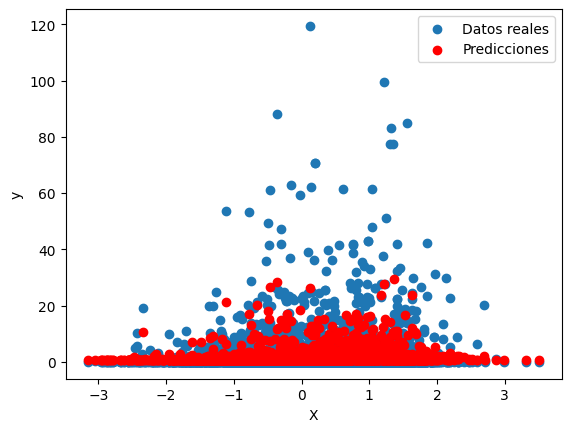

In [66]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_reg_scld, y_test_reg)
print(f'Loss en conjunto de prueba: {loss}')

# Obtener predicciones del modelo
predictions = model.predict(X_test_reg_scld)

# Visualizar los resultados de la regresión
plt.scatter(X_test_reg_scld[:, 0], y_test_reg, label='Datos reales')
plt.scatter(X_test_reg_scld[:, 0], predictions, color='red', label='Predicciones')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [84]:
predictions

array([[0.6214111 ],
       [1.0577548 ],
       [9.0056095 ],
       ...,
       [0.61906374],
       [0.9479526 ],
       [0.66438794]], dtype=float32)

In [67]:
mse_nn = mean_squared_error(y_test_reg, predictions, squared= False)
mae_nn = mean_absolute_error(y_test_reg, predictions)
r2_nn = r2_score(y_test_reg, predictions)

# Imprimir métricas
print(f'Mean Squared Error (MSE): {mse_nn:.4f}')
print(f'Mean Absolute Error (MAE): {mae_nn:.4f}')
print(f'R2: {r2_nn:.4f}')

Mean Squared Error (MSE): 6.9313
Mean Absolute Error (MAE): 2.6026
R2: 0.2390


In [68]:
df_resultados_regresiones

,Modelo,R²,MSE
0,Regresión Lineal,0.226477,6.987998
1,Ridge,0.224189,6.998328
2,Lasso,0.219061,7.021415


## Voy a elegir el modelo de red neuronal de regresion

Aplicamos SHAP a la Red Neuronal de regresion

# Interpretabilidad Local

In [69]:
explainer = shap.DeepExplainer(model, X_train_reg_scld)

In [70]:
shap_values = explainer.shap_values(X_test_reg_scld)

In [71]:
shap_values[0].shape

(3021, 35)

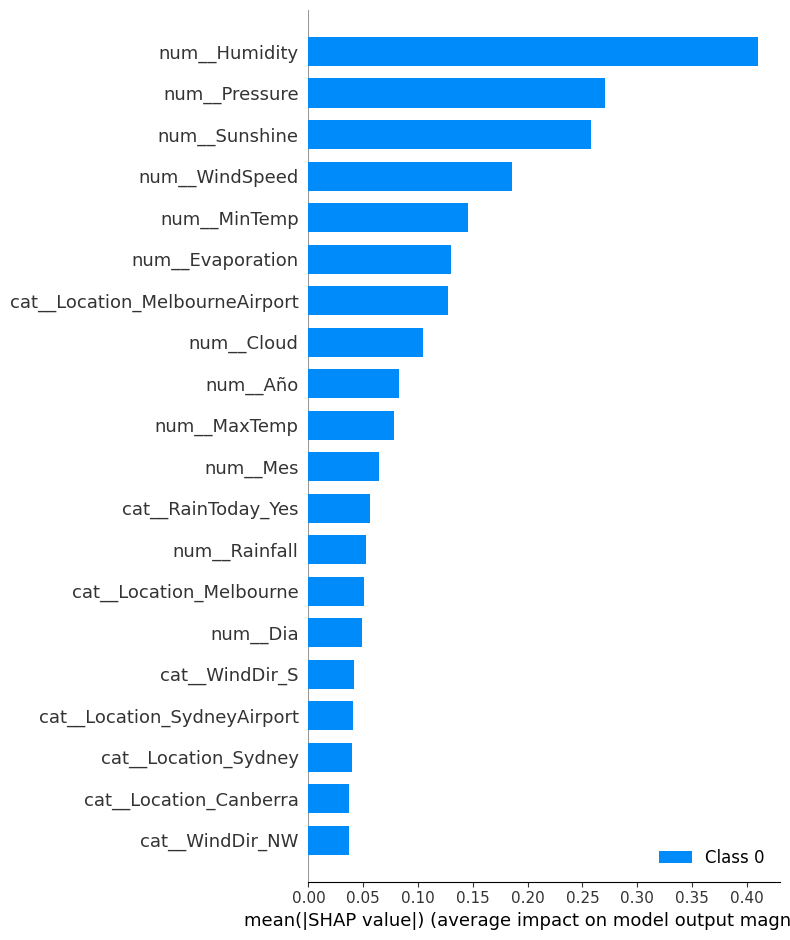

In [72]:
shap.summary_plot(shap_values, X_test_reg_scld, feature_names=feature_names_after_preprocessing)

In [73]:
shap_values[0][0]

array([-0.13332485, -0.04020764, -0.00887699, -0.0105448 , -0.21083608,
        0.0359998 , -0.2510248 , -0.06511214,  0.03098513, -0.14459281,
        0.11752743,  0.01266565, -0.04585493,  0.01922192,  0.04215407,
       -0.02623858,  0.02460719, -0.03254516, -0.04284491,  0.00425751,
        0.00472262,  0.00176261, -0.01289509, -0.00356009, -0.00184931,
       -0.00139796,  0.00686851,  0.02682913, -0.00350141, -0.18511217,
       -0.0003015 , -0.00029275,  0.00776945,  0.00269999,  0.00164359])

In [74]:
explanation = shap.Explanation(values=shap_values[0][0], base_values=explainer.expected_value.numpy()[0], feature_names=feature_names_after_preprocessing)

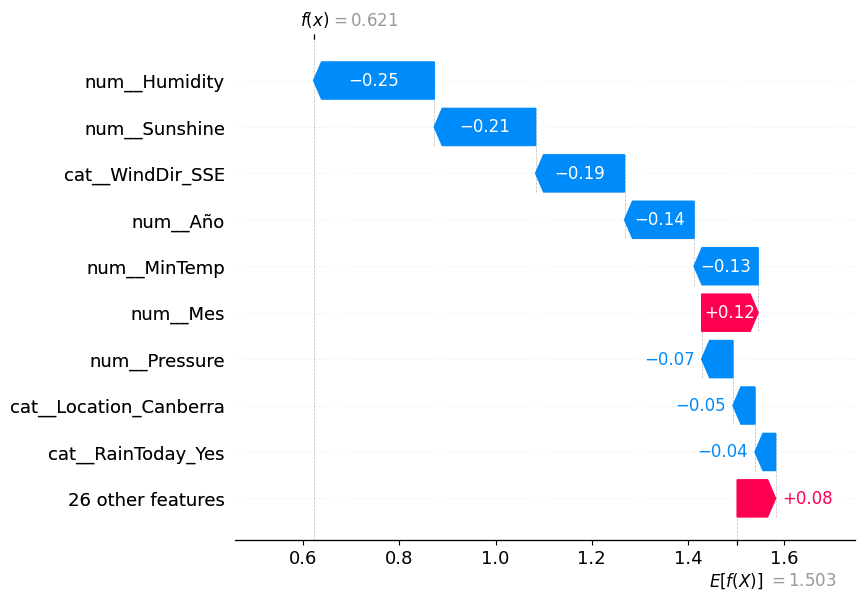

In [75]:
shap.plots.waterfall(explanation)

Exporto el modelo y el Transformer

In [81]:
joblib.dump(model , 'NN_Regressor.pkl')
joblib.dump(preprocessor_Reg , 'Preprocessor_reg.pkl')

['Preprocessor_reg.pkl']

In [83]:
preprocessor_Reg.get_params

<bound method ColumnTransformer.get_params of ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['MinTemp', 'MaxTemp', 'Rainfall',
                                  'Evaporation', 'Sunshine', 'WindSpeed',
                                  'Humidity', 'Pressure', 'Cloud', 'Año', 'Mes',
                                  'Dia']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Location', 'RainToday', 'WindDir'])])>